In [ ]:
%load_ext autoreload
%autoreload 2

In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    train_test_split,
)

from noshow.features.feature_pipeline import create_features
from noshow.preprocessing.load_data import (
    load_appointment_csv,
    process_appointments,
    process_postal_codes,
)

from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

In [7]:
appointments_df = load_appointment_csv("../data/raw/poliafspraken_no_show.csv")
appointments_df = process_appointments(appointments_df)
all_postalcodes = process_postal_codes("../data/raw/NL.txt")
featuretable = create_features(
    appointments_df, all_postalcodes, minutes_early_cutoff=30
)

featuretable = (
    featuretable[
        [
            "hoofdagenda",
            "hour",
            "weekday",
            "minutesDuration",
            "no_show",
            "prev_no_show",
            "prev_no_show_perc",
            "age",
            "dist_umcu",
            "prev_minutes_early",
            "earlier_appointments",
            "appointments_same_day",
            "appointments_last_days",
            "days_since_created",
            "days_since_last_appointment",
        ]
    ]
    .reset_index()
    .set_index(["pseudo_id", "start", "hoofdagenda"])
)

In [8]:
featuretable["no_show"] = (
    featuretable["no_show"].replace({"no_show": "1", "show": "0"}).astype(int)
)
featuretable["hour"] = featuretable["hour"].astype("category")
featuretable["weekday"] = featuretable["weekday"].astype("category")

print(featuretable.dtypes)
X, y = featuretable.drop(columns="no_show"), featuretable["no_show"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=False
)


hour                           category
weekday                        category
minutesDuration                   int64
no_show                           int64
prev_no_show                    float64
prev_no_show_perc               float64
age                               int64
dist_umcu                       float64
prev_minutes_early              float64
earlier_appointments            float64
appointments_same_day             int64
appointments_last_days          float64
days_since_created                int64
days_since_last_appointment     float64
dtype: object


In [15]:
# save feature table to parquet
featuretable.to_parquet("../data/processed/featuretable.parquet")

In [9]:
lgboost_model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=300,
    categorical_features=["hour", "weekday"],
    random_state=42,
)

In [10]:
fitted_model = lgboost_model.fit(X_train, y_train)
preds = fitted_model.predict_proba(X_test)

## ROC curve

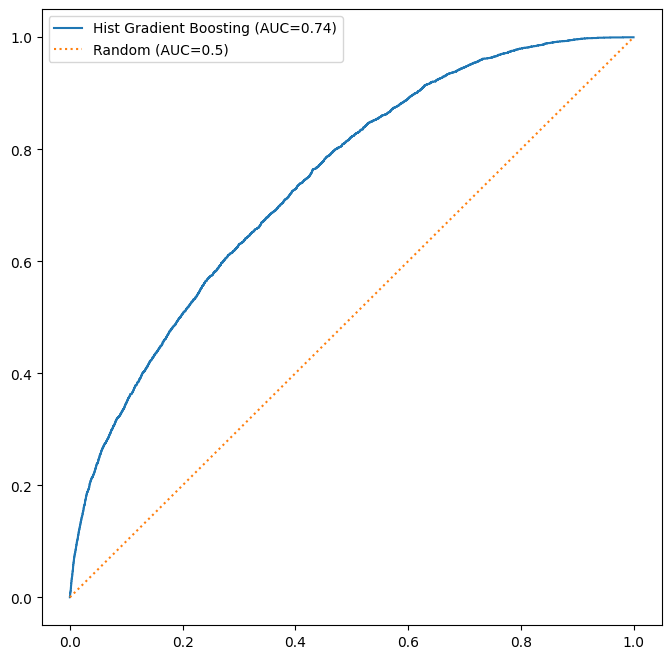

In [11]:
y_pred = fitted_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
auc_score = roc_auc_score(y_test, y_pred[:, 1])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, label=f"Hist Gradient Boosting (AUC={round(auc_score, 2)})")
ax.plot([0, 1], [0, 1], label="Random (AUC=0.5)", linestyle="dotted")
ax.legend()
plt.show()

## Prediction, recall

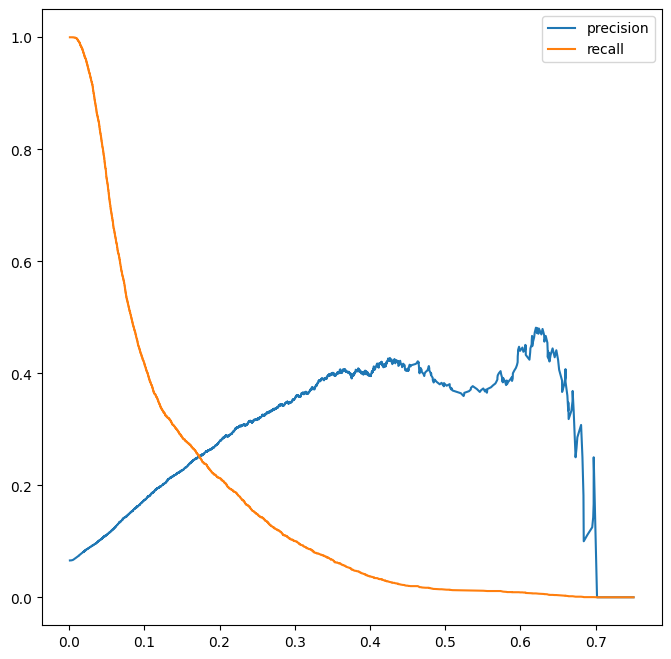

In [12]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(thresholds, precision[:-1], label="precision")
ax.plot(thresholds, recall[:-1], label="recall")
ax.legend()
plt.show()

## Create fixed bins

In [24]:
prediction_df = pd.DataFrame(
        y_pred[:, 1], index=X_test.index, columns=["prediction"]
    )
prediction_df = prediction_df.reset_index()

In [28]:
# Calculate quantiles
n_bins = 4
quantiles = np.linspace(0, 1, n_bins + 1)
# determine quantiles for every hoofdagenda group in preditcions_df
bin_edges = (prediction_df.sort_values("prediction", ascending=False)
             .drop_duplicates(subset="pseudo_id", keep="first")
             .groupby('hoofdagenda')['prediction'].quantile(quantiles).reset_index())

bin_edges = pd.pivot_table(bin_edges, values='prediction', index='hoofdagenda', columns='level_1')
# create a dict where hoodagendas are keys and bin_edges for the quantiles are values
bin_edges = bin_edges.to_dict(orient='index')

# save to json
with open('../data/processed/fixed_pred_score_bin.json', 'w') as f:
    json.dump(bin_edges, f)
print(bin_edges)

{'Centrum voor Thuisbeademing': {0.0: 0.002869026080629313, 0.25: 0.02363319683408826, 0.5: 0.04059144749602261, 0.75: 0.059591663722428606, 1.0: 0.5254072302044027}, 'Kind-Algemene Pediatrie': {0.0: 0.012488333413795575, 0.25: 0.050319764837723865, 0.5: 0.06520545041975814, 0.75: 0.08532207297448731, 1.0: 0.44644177001161}, 'Kind-Dermatologie': {0.0: 0.011574650104220924, 0.25: 0.0575455456226469, 0.5: 0.07463324847274054, 0.75: 0.09826881735687008, 1.0: 0.6733263195394938}, 'Kind-Endocrinologie': {0.0: 0.004089617667788545, 0.25: 0.041306449810217055, 0.5: 0.05483924767785746, 0.75: 0.07566277608126483, 1.0: 0.4788276158882806}, 'Kind-KLZ': {0.0: 0.02097363646728535, 0.25: 0.04592560627296392, 0.5: 0.05948618261033177, 0.75: 0.0798531536288039, 1.0: 0.3064220267008882}, 'Kind-Nefrologie': {0.0: 0.013846399531074773, 0.25: 0.04308932496587094, 0.5: 0.05800396859502832, 0.75: 0.08044801574560079, 1.0: 0.43513469074985844}, 'Longziekten': {0.0: 0.004365271748726063, 0.25: 0.023490393451